In [1]:
import dask.distributed, os
import xarray, numpy
import matplotlib.pyplot as plt
import glob

Explicitly open a Dask cluster,

In [2]:
!hostname

neshcl124


In [3]:
cluster = dask.distributed.LocalCluster(
    n_workers=1,
    local_directory=os.getenv('TMPDIR'),
    ip='0.0.0.0',
)

In [4]:
client = dask.distributed.Client(cluster); client

Connection method: Cluster object,Cluster type: LocalCluster
Dashboard: http://10.0.4.124:8787/status,
Status: running,Using processes: True
Dashboard: http://10.0.4.124:8787/status,Workers: 1
Total threads: 16,Total memory: 80.00 GiB
Comm: tcp://10.0.4.124:40683,Workers: 1
Dashboard: http://10.0.4.124:8787/status,Total threads: 16
Started: Just now,Total memory: 80.00 GiB
Comm: tcp://10.0.4.124:33393,Total threads: 16
Dashboard: http://10.0.4.124:43061/status,Memory: 80.00 GiB
Nanny: tcp://10.0.4.124:35481,


Specify file paths,

In [5]:
source_path='/gxfs_work1/geomar/smomw355/model_data/ocean-only/VIKING20X.L46-KFS003/nemo/output'
target_path='/gxfs_work1/geomar/smomw260/github/ESM-VFC-cloud-project'

Specify data conversion helper functions,

In [6]:
def open_mfdataset(source, variables, chunks):
    files = glob.glob(source)
    da = []
    for file in files:
        da.append(
            xarray.open_dataset(file, chunks=chunks)[variables].reset_coords()
        )
    return da

In [7]:
def concat_and_cleanup_mfdataset(source, variables, chunks):
    # Open single files as Dask arrays...
    da = open_mfdataset(
        source, variables=variables, chunks=chunks
    )
    # Concatenate single file Dask arrays...
    with dask.config.set(**{'array.slicing.split_large_chunks': True}):
        ds = xarray.concat(
            da, dim='time_counter', compat='equals'
        ).sortby('time_counter')
    # Remove encodings...
    ds.encoding = {}
    for key in list(ds.keys()):
        ds[key].encoding = {}
    for key in list(ds.coords.keys()):
        ds[key].encoding = {}
    # Manual coordinate sanitization...
    plt.figure(); ds['nav_lat'].std('time_counter').plot()
    plt.figure(); ds['nav_lon'].std('time_counter').plot()
    ds['nav_lat'] = ds['nav_lat'].mean('time_counter')
    ds['nav_lon'] = ds['nav_lon'].mean('time_counter')
    # https://stackoverflow.com/questions/4843158/how-to-check-if-a-string-is-a-substring-of-items-in-a-list-of-strings
    for key in [s for s in list(ds.dims) if 'depth' in s]:
        depth = numpy.array([da[i][key].values for i in range(len(da))])
        plt.figure(); plt.plot(numpy.std(depth, axis=0))
        ds[key] = numpy.mean(depth, axis=0)
    return ds, da

In [8]:
def open_cleanup_store_mfdataset(source, variables, chunks, target):
    ds, _ = concat_and_cleanup_mfdataset(source, variables, chunks)
    ds.to_zarr(target)

Specify Google pricing,
> 0.0220584 EUR per gibibyte month, for 0.161290323 gibibyte month and above, per day per project

https://cloud.google.com/skus/?currency=EUR&filter=4F25-2496-5269

In [9]:
euro_per_gibibyte = 0.0220584

## Base model data (monthly)

Check netCDF file chunk sizes,

In [10]:
glob.glob(source_path+'/VIKING20X.L46-KFS003_1m_1958*_grid_*.nc')

['/gxfs_work1/geomar/smomw355/model_data/ocean-only/VIKING20X.L46-KFS003/nemo/output/VIKING20X.L46-KFS003_1m_19580101_19581231_grid_T.nc',
 '/gxfs_work1/geomar/smomw355/model_data/ocean-only/VIKING20X.L46-KFS003/nemo/output/VIKING20X.L46-KFS003_1m_19580101_19581231_grid_U.nc',
 '/gxfs_work1/geomar/smomw355/model_data/ocean-only/VIKING20X.L46-KFS003/nemo/output/VIKING20X.L46-KFS003_1m_19580101_19581231_grid_V.nc']

In [11]:
!ncdump -sh "$source_path/VIKING20X.L46-KFS003_1m_19580101_19581231_grid_T.nc" | grep '_ChunkSizes'

		nav_lat:_ChunkSizes = 1021, 1442 ;
		nav_lon:_ChunkSizes = 1021, 1442 ;
		time_centered:_ChunkSizes = 1 ;
		time_centered_bounds:_ChunkSizes = 1, 2 ;
		time_counter:_ChunkSizes = 1 ;
		time_counter_bounds:_ChunkSizes = 1, 2 ;
		votemper:_ChunkSizes = 1, 46, 1021, 1442 ;
		vosaline:_ChunkSizes = 1, 46, 1021, 1442 ;
		sosstsst:_ChunkSizes = 1, 1021, 1442 ;
		sosaline:_ChunkSizes = 1, 1021, 1442 ;
		sossheig:_ChunkSizes = 1, 1021, 1442 ;
		sorunoff:_ChunkSizes = 1, 1021, 1442 ;
		somxl010:_ChunkSizes = 1, 1021, 1442 ;
		sowaflup:_ChunkSizes = 1, 1021, 1442 ;
		soshfldo:_ChunkSizes = 1, 1021, 1442 ;
		sohefldo:_ChunkSizes = 1, 1021, 1442 ;
		somixhgt:_ChunkSizes = 1, 1021, 1442 ;
		sowindsp:_ChunkSizes = 1, 1021, 1442 ;
		sohefldp:_ChunkSizes = 1, 1021, 1442 ;
		sowafldp:_ChunkSizes = 1, 1021, 1442 ;
		sobowlin:_ChunkSizes = 1, 1021, 1442 ;


In [12]:
!ncdump -sh "$source_path/VIKING20X.L46-KFS003_1m_19580101_19581231_grid_U.nc" | grep '_ChunkSizes'

		nav_lat:_ChunkSizes = 1021, 1442 ;
		nav_lon:_ChunkSizes = 1021, 1442 ;
		time_centered:_ChunkSizes = 1 ;
		time_centered_bounds:_ChunkSizes = 1, 2 ;
		time_counter:_ChunkSizes = 1 ;
		time_counter_bounds:_ChunkSizes = 1, 2 ;
		vozocrtx:_ChunkSizes = 1, 46, 1021, 1442 ;
		sozotaux:_ChunkSizes = 1, 1021, 1442 ;


In [13]:
!ncdump -sh "$source_path/VIKING20X.L46-KFS003_1m_19580101_19581231_grid_V.nc" | grep '_ChunkSizes'

		nav_lat:_ChunkSizes = 1021, 1442 ;
		nav_lon:_ChunkSizes = 1021, 1442 ;
		time_centered:_ChunkSizes = 1 ;
		time_centered_bounds:_ChunkSizes = 1, 2 ;
		time_counter:_ChunkSizes = 1 ;
		time_counter_bounds:_ChunkSizes = 1, 2 ;
		vomecrty:_ChunkSizes = 1, 46, 1021, 1442 ;
		sometauy:_ChunkSizes = 1, 1021, 1442 ;


Convert grid variables,

CPU times: user 27 s, sys: 2.37 s, total: 29.3 s
Wall time: 4min 17s


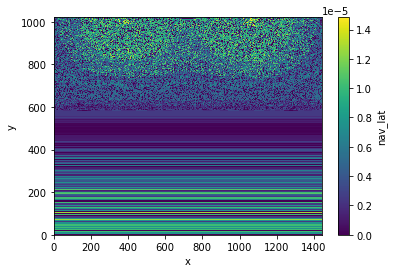

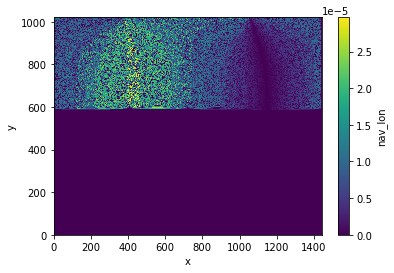

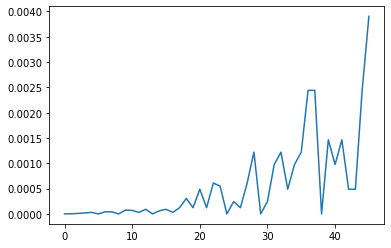

In [14]:
%%time

source = source_path+'/VIKING20X.L46-KFS003_1m_*_grid_T.nc'
target = target_path+'/VIKING20X.L46-KFS003_1m_grid_T.zarr'

open_cleanup_store_mfdataset(
    source=source,
    variables=['votemper', 'vosaline'],
    # votemper:_ChunkSizes = 1, 46, 1021, 1442 ;
    # vosaline:_ChunkSizes = 1, 46, 1021, 1442 ;
    chunks={'time_counter': 1, 'deptht': 46, 'y': 1021, 'x': 1442},
    target=target
)


CPU times: user 12.9 s, sys: 1.14 s, total: 14 s
Wall time: 1min 59s


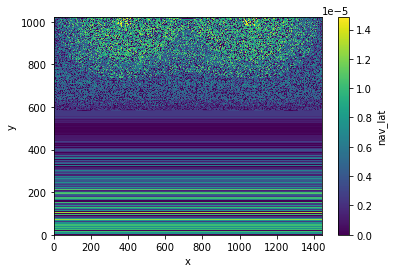

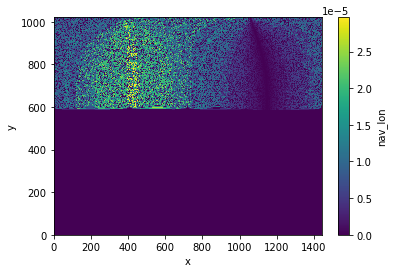

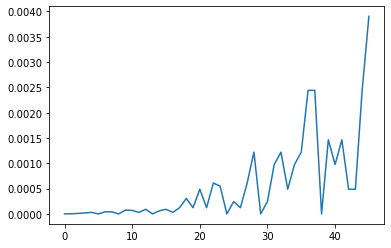

In [15]:
%%time

source = source_path+'/VIKING20X.L46-KFS003_1m_*_grid_U.nc'
target = target_path+'/VIKING20X.L46-KFS003_1m_grid_U.zarr'

open_cleanup_store_mfdataset(
    source=source,
    variables=['vozocrtx'],
    # vozocrtx:_ChunkSizes = 1, 46, 1021, 1442 ;
    chunks={'time_counter': 1, 'deptht': 46, 'y': 1021, 'x': 1442},
    target=target
)


CPU times: user 13.9 s, sys: 1.31 s, total: 15.2 s
Wall time: 2min 4s


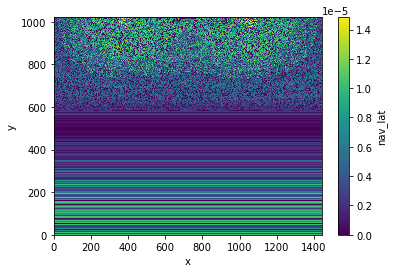

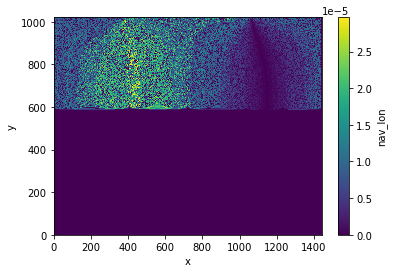

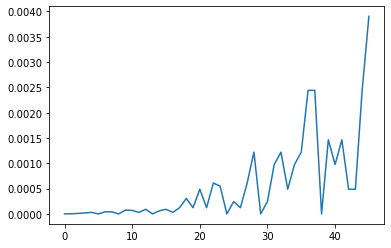

In [16]:
%%time

source = source_path+'/VIKING20X.L46-KFS003_1m_*_grid_V.nc'
target = target_path+'/VIKING20X.L46-KFS003_1m_grid_V.zarr'

open_cleanup_store_mfdataset(
    source=source,
    variables=['vomecrty'],
    # vomecrty:_ChunkSizes = 1, 46, 1021, 1442 ;
    chunks={'time_counter': 1, 'deptht': 46, 'y': 1021, 'x': 1442},
    target=target
)


Check zarr stores,

CPU times: user 7.48 s, sys: 497 ms, total: 7.98 s
Wall time: 32.6 s


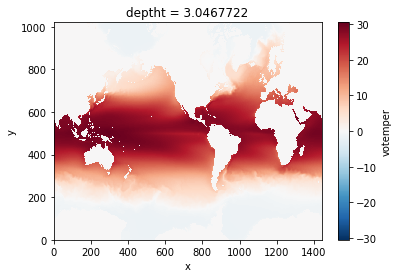

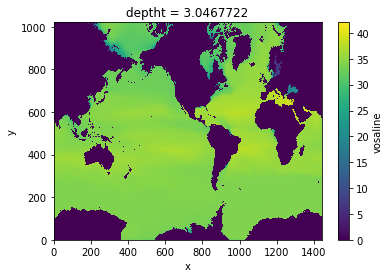

In [17]:
%%time
ds = xarray.open_zarr(target_path+'/VIKING20X.L46-KFS003_1m_grid_T.zarr')
plt.figure(); ds['votemper'].isel(deptht=0).mean('time_counter').plot()
plt.figure(); ds['vosaline'].isel(deptht=0).mean('time_counter').plot()

CPU times: user 3.98 s, sys: 303 ms, total: 4.29 s
Wall time: 22.5 s


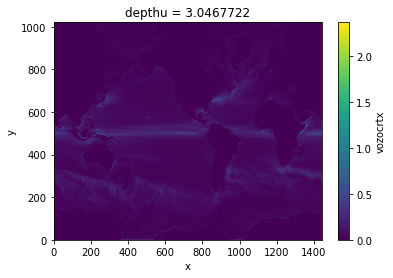

In [18]:
%%time
ds = xarray.open_zarr(target_path+'/VIKING20X.L46-KFS003_1m_grid_U.zarr')
plt.figure(); ds['vozocrtx'].isel(depthu=0).std('time_counter').plot()

CPU times: user 4.27 s, sys: 322 ms, total: 4.59 s
Wall time: 22.3 s


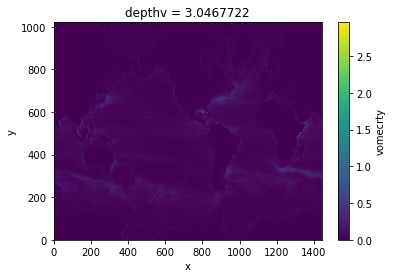

In [19]:
%%time
ds = xarray.open_zarr(target_path+'/VIKING20X.L46-KFS003_1m_grid_V.zarr')
plt.figure(); ds['vomecrty'].isel(depthv=0).std('time_counter').plot()

Total base model data storage costs,

In [20]:
total_storage_gibibytes = []

In [21]:
!du --block-size=1G --summarize "$target_path/VIKING20X.L46-KFS003_1m_grid_T.zarr"

113	/gxfs_work1/geomar/smomw260/github/ESM-VFC-cloud-project/VIKING20X.L46-KFS003_1m_grid_T.zarr


In [22]:
print(113*euro_per_gibibyte, 'euro per month')
total_storage_gibibytes.append(113)

2.4925992 euro per month


In [23]:
!du --block-size=1G --summarize "$target_path/VIKING20X.L46-KFS003_1m_grid_U.zarr"

79	/gxfs_work1/geomar/smomw260/github/ESM-VFC-cloud-project/VIKING20X.L46-KFS003_1m_grid_U.zarr


In [24]:
print(79*euro_per_gibibyte, 'euro per month')
total_storage_gibibytes.append(79)

1.7426135999999999 euro per month


In [25]:
!du --block-size=1G --summarize "$target_path/VIKING20X.L46-KFS003_1m_grid_V.zarr"

81	/gxfs_work1/geomar/smomw260/github/ESM-VFC-cloud-project/VIKING20X.L46-KFS003_1m_grid_V.zarr


In [26]:
print(81*euro_per_gibibyte, 'euro per month')
total_storage_gibibytes.append(81)

1.7867304 euro per month


In [27]:
total_storage_gibibytes

[113, 79, 81]

In [28]:
print(sum(total_storage_gibibytes)*euro_per_gibibyte, 'euro per month')

6.0219432 euro per month


## Atlantic nest model data (monthly)

Check netCDF file chunk sizes,

In [29]:
glob.glob(source_path+'/1_VIKING20X.L46-KFS003_1m_1958*_grid_*.nc')

['/gxfs_work1/geomar/smomw355/model_data/ocean-only/VIKING20X.L46-KFS003/nemo/output/1_VIKING20X.L46-KFS003_1m_19580101_19581231_grid_T.nc',
 '/gxfs_work1/geomar/smomw355/model_data/ocean-only/VIKING20X.L46-KFS003/nemo/output/1_VIKING20X.L46-KFS003_1m_19580101_19581231_grid_U.nc',
 '/gxfs_work1/geomar/smomw355/model_data/ocean-only/VIKING20X.L46-KFS003/nemo/output/1_VIKING20X.L46-KFS003_1m_19580101_19581231_grid_V.nc']

In [30]:
!ncdump -sh "$source_path/1_VIKING20X.L46-KFS003_1m_19580101_19581231_grid_T.nc" | grep '_ChunkSizes'

		nav_lat:_ChunkSizes = 2499, 2404 ;
		nav_lon:_ChunkSizes = 2499, 2404 ;
		time_centered:_ChunkSizes = 1 ;
		time_centered_bounds:_ChunkSizes = 1, 2 ;
		time_counter:_ChunkSizes = 1 ;
		time_counter_bounds:_ChunkSizes = 1, 2 ;
		votemper:_ChunkSizes = 1, 1, 2499, 2404 ;
		vosaline:_ChunkSizes = 1, 1, 2499, 2404 ;
		sosstsst:_ChunkSizes = 1, 2499, 2404 ;
		sosaline:_ChunkSizes = 1, 2499, 2404 ;
		sossheig:_ChunkSizes = 1, 2499, 2404 ;
		sorunoff:_ChunkSizes = 1, 2499, 2404 ;
		somxl010:_ChunkSizes = 1, 2499, 2404 ;
		sowaflup:_ChunkSizes = 1, 2499, 2404 ;
		soshfldo:_ChunkSizes = 1, 2499, 2404 ;
		sohefldo:_ChunkSizes = 1, 2499, 2404 ;
		somixhgt:_ChunkSizes = 1, 2499, 2404 ;
		sowindsp:_ChunkSizes = 1, 2499, 2404 ;
		sohefldp:_ChunkSizes = 1, 2499, 2404 ;
		sowafldp:_ChunkSizes = 1, 2499, 2404 ;
		sobowlin:_ChunkSizes = 1, 2499, 2404 ;


In [31]:
!ncdump -sh "$source_path/1_VIKING20X.L46-KFS003_1m_19580101_19581231_grid_U.nc" | grep '_ChunkSizes'

		nav_lat:_ChunkSizes = 2499, 2404 ;
		nav_lon:_ChunkSizes = 2499, 2404 ;
		time_centered:_ChunkSizes = 1 ;
		time_centered_bounds:_ChunkSizes = 1, 2 ;
		time_counter:_ChunkSizes = 1 ;
		time_counter_bounds:_ChunkSizes = 1, 2 ;
		vozocrtx:_ChunkSizes = 1, 1, 2499, 2404 ;
		sozotaux:_ChunkSizes = 1, 2499, 2404 ;


In [32]:
!ncdump -sh "$source_path/1_VIKING20X.L46-KFS003_1m_19580101_19581231_grid_V.nc" | grep '_ChunkSizes'

		nav_lat:_ChunkSizes = 2499, 2404 ;
		nav_lon:_ChunkSizes = 2499, 2404 ;
		time_centered:_ChunkSizes = 1 ;
		time_centered_bounds:_ChunkSizes = 1, 2 ;
		time_counter:_ChunkSizes = 1 ;
		time_counter_bounds:_ChunkSizes = 1, 2 ;
		vomecrty:_ChunkSizes = 1, 1, 2499, 2404 ;
		sometauy:_ChunkSizes = 1, 2499, 2404 ;


Convert grid variables,

CPU times: user 32min 2s, sys: 54.9 s, total: 32min 57s
Wall time: 2h 11min 24s


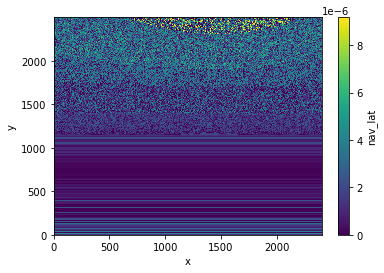

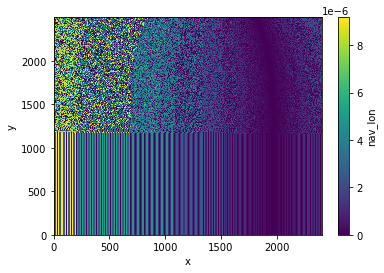

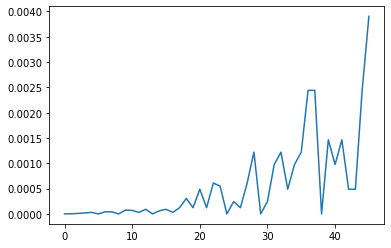

In [33]:
%%time

source = source_path+'/1_VIKING20X.L46-KFS003_1m_*_grid_T.nc'
target = target_path+'/1_VIKING20X.L46-KFS003_1m_grid_T.zarr'

open_cleanup_store_mfdataset(
    source=source,
    variables=['votemper', 'vosaline'],
    # votemper:_ChunkSizes = 1, 1, 2499, 2404 ;
    # vosaline:_ChunkSizes = 1, 1, 2499, 2404 ;
    chunks={'time_counter': 1, 'deptht': 1, 'y': 2499, 'x': 2404},
    target=target
)


CPU times: user 41.1 s, sys: 3.86 s, total: 44.9 s
Wall time: 10min 16s


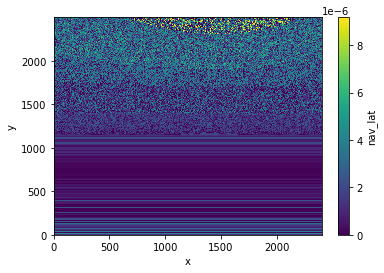

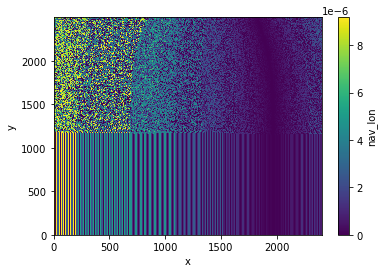

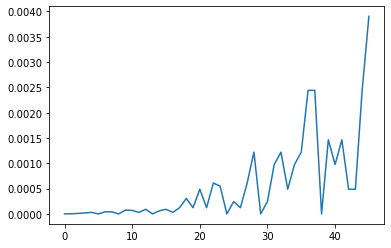

In [34]:
%%time

source = source_path+'/1_VIKING20X.L46-KFS003_1m_*_grid_U.nc'
target = target_path+'/1_VIKING20X.L46-KFS003_1m_grid_U.zarr'

open_cleanup_store_mfdataset(
    source=source,
    variables=['vozocrtx'],
    # vozocrtx:_ChunkSizes = 1, 1, 2499, 2404 ;
    chunks={'time_counter': 1, 'deptht': 1, 'y': 2499, 'x': 2404},
    target=target
)


CPU times: user 36.5 s, sys: 3.08 s, total: 39.5 s
Wall time: 9min 47s


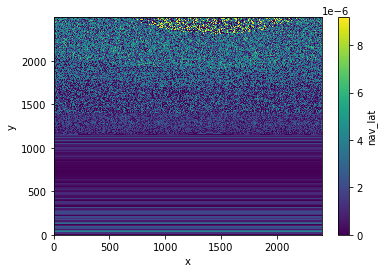

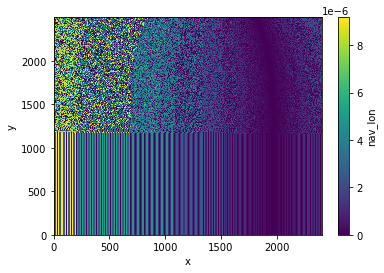

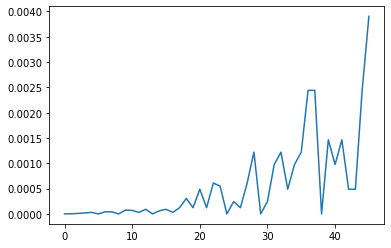

In [35]:
%%time

source = source_path+'/1_VIKING20X.L46-KFS003_1m_*_grid_V.nc'
target = target_path+'/1_VIKING20X.L46-KFS003_1m_grid_V.zarr'

open_cleanup_store_mfdataset(
    source=source,
    variables=['vomecrty'],
    # vomecrty:_ChunkSizes = 1, 1, 2499, 2404 ;
    chunks={'time_counter': 1, 'deptht': 1, 'y': 2499, 'x': 2404},
    target=target
)


Check zarr stores,

CPU times: user 5.11 s, sys: 255 ms, total: 5.36 s
Wall time: 19.2 s


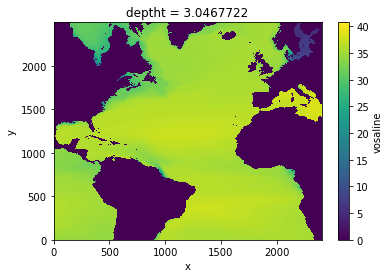

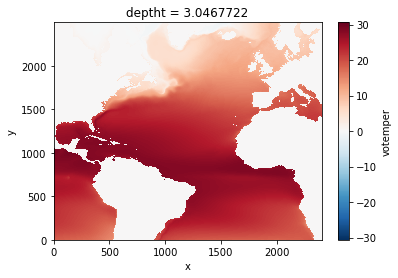

In [36]:
%%time
ds = xarray.open_zarr(target_path+'/1_VIKING20X.L46-KFS003_1m_grid_T.zarr')
plt.figure(); ds['vosaline'].isel(deptht=0).mean('time_counter').plot()
plt.figure(); ds['votemper'].isel(deptht=0).mean('time_counter').plot()

CPU times: user 8.25 s, sys: 602 ms, total: 8.85 s
Wall time: 1min 10s


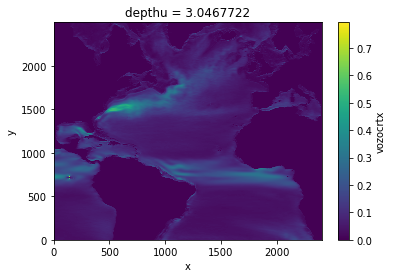

In [37]:
%%time
ds = xarray.open_zarr(target_path+'/1_VIKING20X.L46-KFS003_1m_grid_U.zarr')
plt.figure(); ds['vozocrtx'].isel(depthu=0).std('time_counter').plot()

CPU times: user 8.3 s, sys: 608 ms, total: 8.9 s
Wall time: 1min 12s


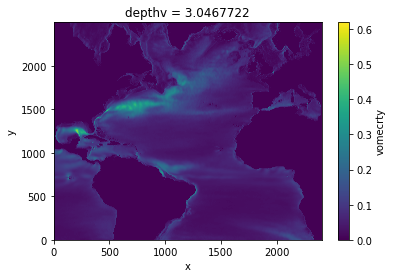

In [38]:
%%time
ds = xarray.open_zarr(target_path+'/1_VIKING20X.L46-KFS003_1m_grid_V.zarr')
plt.figure(); ds['vomecrty'].isel(depthv=0).std('time_counter').plot()

Total nest model data storage costs,

In [39]:
total_storage_gibibytes = []

In [41]:
!du --block-size=1G --summarize "$target_path/1_VIKING20X.L46-KFS003_1m_grid_T.zarr"

406	/gxfs_work1/geomar/smomw260/github/ESM-VFC-cloud-project/1_VIKING20X.L46-KFS003_1m_grid_T.zarr


In [42]:
print(406*euro_per_gibibyte, 'euro per month')
total_storage_gibibytes.append(406)

8.9557104 euro per month


In [43]:
!du --block-size=1G --summarize "$target_path/1_VIKING20X.L46-KFS003_1m_grid_U.zarr"

289	/gxfs_work1/geomar/smomw260/github/ESM-VFC-cloud-project/1_VIKING20X.L46-KFS003_1m_grid_U.zarr


In [44]:
print(289*euro_per_gibibyte, 'euro per month')
total_storage_gibibytes.append(289)

6.3748776 euro per month


In [45]:
!du --block-size=1G --summarize "$target_path/1_VIKING20X.L46-KFS003_1m_grid_V.zarr"

296	/gxfs_work1/geomar/smomw260/github/ESM-VFC-cloud-project/1_VIKING20X.L46-KFS003_1m_grid_V.zarr


In [46]:
print(296*euro_per_gibibyte, 'euro per month')
total_storage_gibibytes.append(296)

6.529286399999999 euro per month


In [47]:
total_storage_gibibytes

[406, 289, 296]

In [48]:
print(sum(total_storage_gibibytes)*euro_per_gibibyte, 'euro per month')

21.8598744 euro per month


## Package versions

In [49]:
pip list

Package                       Version
----------------------------- --------------------------
adal                          1.2.7
adlfs                         2021.7.1
affine                        2.3.0
aiobotocore                   1.3.3
aiohttp                       3.7.4.post0
aioitertools                  0.7.1
alembic                       1.6.5
amqp                          5.0.6
anyio                         3.2.1
appdirs                       1.4.4
argon2-cffi                   20.1.0
asciitree                     0.3.3
asgiref                       3.4.1
asn1crypto                    1.4.0
astropy                       4.2.1
async-generator               1.10
async-timeout                 3.0.1
attrs                         21.2.0
av                            8.0.3
awscli                        1.19.106
azure-core                    1.14.0
azure-datalake-store          0.0.51
azure-identity                1.6.0
azure-storage-blob            12.8.1
Babel                    

In [50]:
!conda list --explicit

# This file may be used to create an environment using:
# $ conda create --name <env> --file <this file>
# platform: linux-64
@EXPLICIT
https://conda.anaconda.org/conda-forge/linux-64/gh-1.12.1-ha8f183a_1.tar.bz2
https://conda.anaconda.org/conda-forge/noarch/nomkl-1.0-h5ca1d4c_0.tar.bz2
https://conda.anaconda.org/conda-forge/linux-64/_libgcc_mutex-0.1-conda_forge.tar.bz2
https://conda.anaconda.org/conda-forge/linux-64/ca-certificates-2021.5.30-ha878542_0.tar.bz2
https://conda.anaconda.org/conda-forge/noarch/font-ttf-dejavu-sans-mono-2.37-hab24e00_0.tar.bz2
https://conda.anaconda.org/conda-forge/noarch/font-ttf-inconsolata-3.000-h77eed37_0.tar.bz2
https://conda.anaconda.org/conda-forge/noarch/font-ttf-source-code-pro-2.038-h77eed37_0.tar.bz2
https://conda.anaconda.org/conda-forge/noarch/font-ttf-ubuntu-0.83-hab24e00_0.tar.bz2
https://conda.anaconda.org/conda-forge/noarch/kernel-headers_linux-64-2.6.32-he073ed8_14.tar.bz2
https://conda.anaconda.org/conda-forge/linux-64/ld_impl_linux-64-2